Reference:  
1)https://pysal.org/spaghetti/notebooks/facility-location.html   
pysal의 spaghetti 모듈을 활용한 입지최적화 예제  
2)https://pysal-spaghetti.readthedocs.io/en/latest/generated/spaghetti.Network.allneighbordistances.html  
spaghetti 모듈에서 도로 기준으로 거리행렬(cost matrix)를 구하기 위한 allneighbor 함수 특성  
3)https://github.com/DonghyunAnn/Gbig-Hackathon/blob/master/notebook/%EC%95%88%EB%8F%99%ED%98%84/MCLP_Roaddata.ipynb  
서울시 시군구 기준 도로 정보에 적용한 참조 코드  

In [ ]:
import warnings
warnings.filterwarnings(action='ignore') #경고 메시지 무시
from IPython.display import display #print가 아닌 display()로 연속 출력

In [ ]:
from collections import OrderedDict
from skimage.transform import resize
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools # 규제항을 달아주기 위해 ortools의 기능 활용
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti # 지도경로를 통해 거리를 구하기 위해서 spaghetti module 가져옴
import sys
from pathlib import Path


In [ ]:
import os # matplotlib에서 한글 출력을 위한 폰트 위치 지정
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/NanumBarunGothic.ttf'
font_name = font_manager.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False 

In [ ]:
class FacilityLocationModel:
    """Solve a facility location optimization model

    Parameters
    ----------
    name : str
        Problem model name; must also be defined as a class method.
    cij : numpy.ndarray
        cost matrix from origins (index of i) to destination (index of j).
        Default is None.
    ai : numpy.ndarray
        Client weight vector. Default is None.
    s : float
        service radius. Default is None.
    p : int
        Density of facilities to site. Default is None.
    write_lp : str
        file name (and path) of the LP file to write out.
    print_sol : bool
        print select results. Default is True.

    Methods
    -------
    build_lscp : build location set covering problem
    build_pmp : build p-median problem
    build_pcp : build p-center problem
    build_mclp : build maximal covering location problem
    add_vars : add variables to a model
    add_constrs : add contraints to a model
    add_obj : add an objective function to a model
    optimize : solve a model
    record_decisions : record optimal decision variables
    non_obj_vals : record non-objective values stats (eg. percent covered)
    print_results : print selected results

    Attributes
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    n_cli : int
        total client sites
    r_cli : range
        iterable of client sites
    n_fac : int
        total candidate facility sites
    r_fac : range
        iterable of candidate facility sites
    aij : numpy.ndarray
        binary coverage matrix from cij (within s service radius)
    sij : numpy.ndarray
        demand weighted cost matrix as (ai * cij).
    fac_vars : dict
        facility decision variables
    cli_vars : dict
        client decision variables
    W : ortools.linear_solver.pywraplp.Variable
        minimized maximum variable in the p-center problem formulation
    lp_formulation : str
        linear programming formulation of the model
    solve_minutes : float
        solve time in minutes
    obj_val : int or float
        model objective value
    fac2cli : dict
        facility to client relationship lookup
    cli2fac : dict
        client to facility relationship lookup
    fac2iloc : dict
        facility to dataframe index location lookup
    n_cli_uncov : int
        count of client location outside the service radius
    cli2ncov : dict
        client to covered by count lookup
    ncov2ncli : dict
        covered by count to client count lookup
    mean_dist :
        mean distance per person to the assigned facility
    perc_served :
        percentage of weighted clients covered in `s`
    """

    def __init__(
        self, name, ai=None, cij=None, s=None, p=None, write_lp=None, print_sol=True
    ):
        # Set model information
        self.name = name
        # create a solver instance
        solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
        # instantiate a model
        self.model = pywraplp.Solver(self.name, solver_instance)

        # Set parameters and indices
        # facility parameter
        if p:
            self.p = p
        # client count and range
        self.cij = cij
        self.n_cli = cij.shape[0]
        self.r_cli = range(self.n_cli)
        # facility count and range
        self.n_fac = self.cij.shape[1]
        self.r_fac = range(self.n_fac)
        # demand parameter
        if ai is not None:
            self.ai = ai
            self.ai_sum = ai.sum()
            # weighted demand
            try:
                self.sij = self.ai * self.cij
            except ValueError:
                self.ai = self.ai.values.reshape(self.n_cli, 1)
                self.sij = self.ai * self.cij
        # if the model has a service radius parameter
        if s:
            self.s = s
            # binary coverage matrix from cij
            self.aij = numpy.zeros(self.cij.shape)
            self.aij[self.cij <= self.s] = 1.0

        # Set decision variables, constraints, and objective function
        try:
            getattr(self, "build_" + self.name)()
        except:
            raise AttributeError(self.name, "not a defined location model.")

        # solve
        self.optimize(write_lp=write_lp)
        # records seleted decision variables
        self.record_decisions()
        # record non-objective values stats (eg. percent covered)
        self.non_obj_vals()
        # print results
        if print_sol:
            self.print_results()

    def build_lscp(self):
        """ Integer programming formulation of the Location Set Covering Problem.
        Originally Published:
            Toregas, C. and ReVelle, Charles. 1972.
            Optimal Location Under Time or Distance Constraints.
            Papers of the Regional Science Association. 28(1):133 - 144.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=1)  # set coverage constraints
        # Objective Function
        self.add_obj()

    def build_pmp(self):
        """Integer programming formulation of the p-median Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
                -1-
            ReVelle, C.S. and Swain, R.W. 1970. Central facilities location.
            Geographical Analysis. 2(1), 30-42.
                -2-
            Toregas, C., Swain, R., ReVelle, C., Bergman, L. 1971. The Location
            of Emergency Service Facilities. Operations Research. 19 (6),
            1363-1373.
                - 3 -
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        # Objective Function
        self.add_obj()

    def build_pcp(self):
        """Integer programming formulation of the p-center Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        self.add_constrs(constr=5)  # minimized maximum constraints
        # Objective Function
        self.add_obj()

    def build_mclp(self):
        """Integer programming formulation of the Maximal Covering Location Problem.
        Originally Published:
            Church, R. L and C. ReVelle. 1974. The Maximal Covering Location
            Problem. Papers of the Regional Science Association. 32:101-18.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=6)  # maximal coverage constraints
        # Objective Function
        self.add_obj()

    def add_vars(self):
        """Add variables to a model."""
        # facility decision variables
        self.fac_vars = {j: self.model.IntVar(0, 1, "y[%i]" % (j)) for j in self.r_fac}
        # client decision variables
        if self.name == "mclp":
            self.cli_vars = {
                (i): self.model.IntVar(0, 1, "x[%i]" % (i)) for i in self.r_cli
            }
        if self.name == "pmp" or self.name == "pcp":
            self.cli_vars = {
                (i, j): self.model.IntVar(0, 1, "x[%i,%i]" % (i, j))
                for i in self.r_cli
                for j in self.r_fac
            }
        # minimized maximum variable
        if self.name == "pcp":
            self.W = self.model.NumVar(0, self.model.infinity(), "W")

    def add_constrs(self, constr=None):
        """ Add constraints to a model.
        (1) set coverage constraints
                y1 + x2 >= 1
                x1 + x3 >= 1
                x2 >= 1
        (2) assignment constraints
                x1_1 + x1_2 + x1_3 = 1
        (3) facility constraints
                y1 + y2 + y3 = p
        (4) opening constraints
                - x1_1 + y1 >= 0
                - x2_1 + y1 >= 0
                - x3_1 + y1 >= 0
        (5) minimax constraints
                cost1_1*x1_1 + cost1_2*x1_2 + cost1_3*x1_3 - W <= 0
        (6) maximal coverage constraints
                - x1 + y1 + y3 >= 0
                - x2 + y4 >= 0
        Parameters
        ----------
        constr : int {1, 2, 3, 4, 5, 6}
            Contraint type to add to model. See above for explanation.
            Default is None.
        """
        # 1 - set covering constraints
        if constr == 1:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= 1
                )
        # 2 - assignment constraints
        elif constr == 2:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum([self.cli_vars[i, j] for j in self.r_fac]) == 1
                )
        # 3 - facility constraint
        elif constr == 3:
            self.model.Add(
                self.model.Sum([self.fac_vars[j] for j in self.r_fac]) == self.p
            )
        # 4 - opening constraints
        elif constr == 4:
            for i in self.r_cli:
                for j in self.r_fac:
                    self.model.Add(self.fac_vars[j] - self.cli_vars[i, j] >= 0)
        # 5 - minimax constraints
        elif constr == 5:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.cij[i, j] * self.cli_vars[i, j] for j in self.r_fac]
                    )
                    <= self.W
                )
        # 6 - max coverage constraints
        elif constr == 6:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= self.cli_vars[i]
                )

    def add_obj(self):
        """Add an objective function to a model."""
        if self.name == "lscp":
            self.model.Minimize(self.model.Sum([self.fac_vars[j] for j in self.r_fac]))

        elif self.name == "pmp":
            obj = [
                self.sij[i, j] * self.cli_vars[i, j]
                for i in self.r_cli
                for j in self.r_fac
            ]
            self.model.Minimize(self.model.Sum(obj))

        elif self.name == "pcp":
            self.model.Minimize(self.W)

        elif self.name == "mclp":
            obj = [self.ai.flatten()[i] * self.cli_vars[i] for i in self.r_cli]
            self.model.Maximize(self.model.Sum(obj))

    def optimize(self, write_lp=False):
        """ Solve the model.
        Parameters
        ----------
        write_lp : bool
            write out the linear programming formulation
        """

        def _redirect_to_file(self, text):
            """ Write out the model in linear programming format.
            Parameters
            ----------
            text : str
                full lp formulation in str format
            """
            original = sys.stdout
            sys.stdout = open(self.name + ".lp", "w")
            print(text)
            sys.stdout = original

        self.model.Solve()
        # linear programming formulation
        if write_lp:
            self.lp_formulation = self.model.ExportModelAsLpFormat(True)
            self._redirect_to_file(self.lp_formulation)
        # WallTime() in milliseconds
        self.solve_minutes = self.model.WallTime() * 1.66667e-5
        self.obj_val = self.model.Objective().Value()

    def record_decisions(self):
        """Record decision variable relationship folowing optimization."""
        # facility-to-dataframe index location lookup
        self.fac2iloc = {v.name(): k for k, v in self.fac_vars.items()}
        # client-to-dataframe index location lookup
        self.cli2iloc = {}
        # facility-to-client lookup
        self.fac2cli = {}

        # record client/service relationships
        for j in self.r_fac:
            if self.fac_vars[j].solution_value() > 0:
                jvar = self.fac_vars[j].name()
                self.fac2cli[jvar] = []
                for i in self.r_cli:
                    ivar = None
                    if self.name == "lscp":
                        if self.aij[i, j] > 0:
                            ivar = "x[%i]" % i
                            self.fac2cli[jvar].append(ivar)
                    elif self.name == "mclp":
                        if self.cli_vars[i].solution_value() > 0:
                            if self.aij[i, j] > 0:
                                ivar = self.cli_vars[i].name()
                                self.fac2cli[jvar].append(ivar)
                    else:
                        if self.cli_vars[i, j].solution_value() > 0:
                            ivar = self.cli_vars[i, j].name()
                            ivar = ivar.split(",")[0] + "]"
                            self.fac2cli[jvar].append(ivar)
                    if ivar:
                        self.cli2iloc[ivar] = i

        # client-to-facility lookup
        self.cli2fac = {}
        for cv in list(self.cli2iloc.keys()):
            self.cli2fac[cv] = []
            for k, v in self.fac2cli.items():
                if cv in v:
                    self.cli2fac[cv].append(k)

        # count of uncovered clients
        self.n_cli_uncov = self.n_cli - len(self.cli2iloc.keys())

        # clients of clients covered by n facilities
        if self.name == "lscp" or self.name == "mclp":
            self.cli2ncov = {}
            for c, fs in self.cli2fac.items():
                self.cli2ncov[c] = len(fs)
            most_coverage = max(self.cli2ncov.values())
            self.ncov2ncli = {}
            for cov_count in range(most_coverage + 1):
                if cov_count == 0:
                    self.ncov2ncli[cov_count] = self.n_cli_uncov
                    continue
                if not cov_count in list(self.cli2ncov.keys()):
                    self.ncov2ncli[cov_count] = 0
                for c, ncov in self.cli2ncov.items():
                    if ncov >= cov_count:
                        self.ncov2ncli[cov_count] += 1

    def non_obj_vals(self):
        """Record non-objective values."""
        if self.name == "pmp":
            self.mean_dist = self.obj_val / float(self.ai_sum)

        if self.name == "mclp":
            self.perc_served = (self.obj_val / float(self.ai_sum)) * 100.0

    def print_results(self):
        """Print select results."""
        print("Solve Time:", self.solve_minutes, "minutes")

        # solve time and objective value
        if self.name == "lscp":
            u1 = "facilities needed for total coverage within a "
            u2 = "%f meter service radius" % self.s
        if self.name == "pmp":
            u1 = "total weighted distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "pcp":
            u1 = "worst case distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "mclp":
            u1 = "residents within %f meters of " % self.s
            u2 = "%i selected facilities" % self.p
        units = u1 + u2

        print("Obj. Value:", self.obj_val, units)

        if self.name == "pmp":
            print("Mean weighted distance per", "person: %f" % self.mean_dist)
        if self.name == "mclp":
            print(
                "Percent of %i" % self.ai_sum, "clients covered: %f" % self.perc_served
            )

        # coverage values
        if self.name == "lscp" or self.name == "mclp":
            for ncov, ncli in self.ncov2ncli.items():
                if ncov == 0:
                    print("--- %i clients are not covered" % ncli)
                else:
                    if ncov == 1:
                        sp = "y"
                    else:
                        sp = "ies"
                    print(
                        "--- %i clients are covered" % ncli,
                        "by %i" % ncov,
                        "facilit" + sp,
                    )

In [ ]:
def add_results(model, cli_df, fac_df, print_solution=False):
    """Add decision variable relationships to a dataframe.
    Parameters
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations
    print_solution : bool
        print out solution decision variables. Default is False.
    Returns
    -------
    cli_df : geopandas.GeoDataFrame
        updated client locations
    fac_df : geopandas.GeoDataFrame
        updated facility locations
    """
    col_name = model.name + "_sol"
    fillers = [[cli_df, "cli2fac"], [fac_df, "fac2cli"]]
    for df, attr in fillers:
        df[col_name] = df["dv"].map(getattr(model, attr))
        df[col_name].fillna("closed", inplace=True)
    if print_solution:
        selected = fac_df[fac_df[col_name] != "closed"]
        for idx in selected.index:
            print("")
            print(selected.loc[idx, "dv"], "serving:", selected.loc[idx, col_name])
    return cli_df, fac_df

In [ ]:
def plotter(
    fig=None,
    base=None,
    plot_aux=None,
    buffered=None,
    model=None,
    pt1_size=None,
    pt2_size=None,
    plot_res=None,
    save_fig=False,
    title=None,
    figsize=(10, 10),
):
    """ Top-level scenario plotter for location analytics.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
        complete figure to plot. Default is None.
    base : matplotlib.axes._subplots.AxesSubplot
        individual axis to plot. Default is None.
    plot_aux : dict
        model data parameters dataframes to plot keyed by
        descriptive names. Default is None.
    plot_res : dict
        model data results dataframes to plot keyed by
        descriptive names. Default is None.
    buffered : see
        buffer distance from roads segments in `plot_base`.
        Default is None.
    pt1_size : float or float
        size of points to plot. `pt1_size` should always be the
        larger between `pt2_size` and `pt1_size`. Default is None.
    pt2_size : float or float
        size of points to plot. Default is None.
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    title : str
        plot title. Default is None.
    figsize : tuple
        Figure size for plot. Default is (12,12).
    save_fig : bool
        Default is False.
    Returns
    -------
    add_to_legend : list
        items to add to legend
    """
    for_multiplot = True
    if not fig and not base:
        for_multiplot = False
        fig, base = plt.subplots(1, 1, figsize=figsize)

    # add title
    if not for_multiplot:
        if model:
            title += " - " + model.name
        base.set_title(title, size=20)

    else:
        base.set_title(model.name, size=20)

    # plot non-results data
    if plot_aux:
        for k, df in plot_aux.items():
            if k == "streets":
                df.plot(ax=base, lw=2, edgecolor="k", zorder=1,color='lavender')
            if k == "border":
                df.plot(ax=base, lw=2, edgecolor="k",alpha=0.5, zorder=1,color='yellow')
                minx, miny, maxx, maxy = df.total_bounds
                base.set_xlim(minx, maxx)
                base.set_ylim(miny, maxy)
                #도로 데이터를 행정동별로 불러올 수 없기 때문에, 전체 구의 도로 데이터를 불러온 후, 선택한 행정동만 plot에 나오도록 변경
            if k == "buffer":
                df.plot(ax=base, facecolor="y", lw=0.25, alpha=0.25, zorder=1)
            if k == "cli_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size / 6.0
                    pcolor = "k"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "r"
                df.plot(ax=base, markersize=psize, edgecolor="k", facecolor=pcolor,aspect=1)
            if k == "fac_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size
                    pcolor = "k"
                    pmarker = "*"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "b"
                    pmarker = "o"
                df.plot(
                    ax=base,
                    markersize=psize,
                    edgecolor="k",
                    facecolor=pcolor,
                    marker=pmarker,
                    aspect=1
                )
                n_fac = df.shape[0]
            if k == "cli_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="r",
                    alpha=0.75,
                    aspect=1
                )
            if k == "fac_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="b",
                    alpha=0.75,
                    aspect=1
                )
        add_to_legend = list(plot_aux.keys())
    else:
        add_to_legend = None

    # plot results data
    if plot_res:
        dv_colors = dv_colorset(plot_res["fac_var"].dv)
        # facilities
        df = plot_res["fac_var"][plot_res["fac_var"][model.name + "_sol"] != "closed"]
        alpha = 0.3
        # decision variable info for legend
        dvs_to_leg = {}
        # plot facilities
        for dv in df.dv:
            fac = df[df.dv == dv]
            fac.plot(
                ax=base,
                marker="*",
                markersize=pt1_size * 3.0,
                alpha=0.8,
                zorder=3,
                edgecolor="k",
                facecolor=dv_colors[dv],
                aspect=1
            )
            # update decision variable info with set color
            dvs_to_leg[dv] = {"facecolor": dv_colors[dv]}
        # plot clients & service areas
        for f, c in model.fac2cli.items():
            fc = plot_res["cli_var"][plot_res["cli_var"].dv.isin(c)]
            fc.plot(
                ax=base,
                markersize=50,
                edgecolor="k",
                facecolor=dv_colors[f],
                alpha=alpha,
                zorder=2,
                aspect=1
            )
            # update decision variable info with set client counts
            dvs_to_leg[f].update({"clients": fc.shape[0]})
            # create service area polygon
            service_area = concave_hull(df, fc, f)
            service_area.plot(
                ax=base, edgecolor="k", alpha=0.2, facecolor=dv_colors[f], zorder=1
            )
    else:
        dvs_to_leg = None

    if not model:

        class _ShellModel:
            """Object to mimic `model` when not present."""

            def __init__(self, plot_aux):
                try:
                    self.n_cli = plot_aux["cli_tru"].shape[0]
                    try:
                        self.n_fac = plot_aux["fac_tru"].shape[0]
                    except KeyError:
                        pass
                except KeyError:
                    pass

        try:
            model = _ShellModel(plot_aux)
        except (TypeError, KeyError):
            model = None

    if not for_multiplot:
        # create legend patches
        patches = create_patches(
            model=model,
            for_multiplot=for_multiplot,
            pt1_size=pt1_size,
            pt2_size=pt2_size,
            buffered=buffered,
            legend_aux=add_to_legend,
            dvs_to_leg=dvs_to_leg,
        )
        add_legend(patches, for_multiplot=for_multiplot)
    add_north_arrow(base)
    add_scale(base)

    if save_fig:
        plt.savefig(model.name + ".png")

    # if for a multiplot explicityly return items to add to legend
    if for_multiplot:
        return add_to_legend

In [ ]:
def multi_plotter(
    models,
    plot_aux=None,
    plot_res=None,
    select=None,
    title=None,
    figsize=(14, 14),
    shape=(2, 2),
):
    """plot multiple base axes as one figure
    Parameters
    ----------
    models : list
        solved model objects
    select : dict
        facility-to-selection count lookup.
    shape : tuple
        dimension for subplot array. Default is (2,2).s
    plot_aux : see plotter()
    plot_res : see plotter()
    title : see plotter()
    figsize : see plotter()
    """
    pt1_size, pt2_size = 300, 60
    # convert list of models to array
    mdls = numpy.array(models).reshape(shape)
    fig, axarr = plt.subplots(
        mdls.shape[0], mdls.shape[1], figsize=figsize, sharex="col", sharey="row"
    )
    # add super title to subplot array
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(hspace=0.1, wspace=0.005, top=0.925)
    # create each subplot
    for i in range(mdls.shape[0]):
        for j in range(mdls.shape[1]):
            add_to_legend = plotter(
                base=axarr[i, j],
                plot_aux=plot_aux,
                plot_res=plot_res,
                model=mdls[i, j],
                pt1_size=pt1_size,
                pt2_size=pt2_size,
            )
            axarr[i, j].set_aspect("equal")
    add_to_legend = set(add_to_legend)
    # decision variable color set
    dv_colors = dv_colorset(plot_res["fac_var"].dv)
    dvs_to_leg = {f: dv_colors[f] for m in models for f in m.fac2cli.keys()}
    # set ordered dict of {iloc:fac_var, color, x-selected}
    # *** models[0] can be any of the solved models
    dvs_to_leg = {
        models[0].fac2iloc[k]: (k, v, select[k]) for k, v in dvs_to_leg.items()
    }
    dvs_to_leg = OrderedDict(sorted(dvs_to_leg.items()))
    # create legend patches
    patches = create_patches(
        model=None,
        pt1_size=pt1_size,
        pt2_size=pt2_size,
        legend_aux=add_to_legend,
        dvs_to_leg=dvs_to_leg,
        for_multiplot=True,
    )

In [ ]:
def add_north_arrow(base):
    """add a north arrow to an axes
    Parameters
    ----------
    base : see plotter()
    """
    arw = "rarrow, pad=0.25"
    bbox_props = dict(boxstyle=arw, fc="w", ec="k", lw=2, alpha=0.75)
    base.text(
        221200,
        267200,
        "      z    ",
        bbox=bbox_props,
        fontsize="large",
        fontweight="heavy",
        ha="center",
        va="center",
        rotation=90,
    )

In [ ]:
def add_scale(base):
    """add a scale bar to an axes
    Parameters
    ----------
    base : see plotter()
    """
    scalebar = ScaleBar(1, units="m", location="lower left")
    base.add_artist(scalebar)
    base.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

In [ ]:
def create_patches(
    model=None,
    pt1_size=None,
    pt2_size=None,
    buffered=None,
    legend_aux=None,
    dvs_to_leg=None,
    for_multiplot=False,
):
    """create all patches to add to the legend.
    Parameters
    ----------
    for_multiplot : bool
        for a single plot (True), or multiplot (False).
        Default is False.
    model : see plotter()
    pt1_size : see plotter()
    pt2_size : see plotter()
    buffered : see plotter()
    legend_aux : see plotter()
    dvs_to_leg : see plotter()
    Returns
    -------
    patches : list
        legend handles matching plotted items
    """
    if pt1_size:
        ms1 = float(pt1_size) / 6.0
    if pt2_size:
        ms2 = float(pt2_size) / 8.0
    # streets -- always plot
    strs = mlines.Line2D([], [], color="k", linewidth=2, alpha=1, label="Streets")
    # all patches to add to legend
    patches = [strs]
    # non-results data
    if legend_aux:
        if "buffer" in legend_aux:
            label = "Street buffer (%sm)" % buffered
            strbuff = mpatches.Patch(
                edgecolor="None", facecolor="y", linewidth=2, alpha=0.5, label=label
            )
            patches.append(strbuff)
        if "cli_tru" in legend_aux:
            try:
                if dvs_to_leg:
                    pcolor = "k"
                    msize = ms2 / 3.0
                    plabel = "Uncovered Households " + "($n$=%i)" % model.n_cli_uncov
                else:
                    pcolor = "r"
                    msize = ms1
                    plabel = "Households ($n$=%i)" % model.n_cli
                cli_tru = mlines.Line2D(
                    [],
                    [],
                    color=pcolor,
                    marker="o",
                    ms=msize,
                    linewidth=0,
                    alpha=1,
                    markeredgecolor="k",
                    label=plabel,
                )
                patches.append(cli_tru)
            except AttributeError:
                pass
        if "fac_tru" in legend_aux:
            if dvs_to_leg:
                pcolor = "k"
                msize = ms2
                pmarker = "*"
                no_fac = model.n_fac - len(list(model.fac2cli.keys()))
                plabel = "Unselected Facilities ($n$=%i)" % no_fac
            else:
                pcolor = "b"
                msize = ms1
                pmarker = "o"
                plabel = "Little Free Library candidates" + "($n$=%i)" % model.n_fac
            fac_tru = mlines.Line2D(
                [],
                [],
                color=pcolor,
                marker=pmarker,
                ms=msize,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=plabel,
            )
            patches.append(fac_tru)
        if "cli_snp" in legend_aux:
            label = "Households snapped to network"
            cli_snp = mlines.Line2D(
                [],
                [],
                color="r",
                marker="o",
                ms=ms2,
                linewidth=0,
                alpha=1,
                markeredgecolor="k",
                label=label,
            )
            patches.append(cli_snp)
        if "fac_snp" in legend_aux:
            label = "LFL candidates snapped to network"
            fac_snp = mlines.Line2D(
                [],
                [],
                color="b",
                marker="o",
                ms=ms2,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=label,
            )
            patches.append(fac_snp)
    # results data for single plot
    if dvs_to_leg and not for_multiplot:
        # add facility, client, and service area patches to legend
        for k, v in dvs_to_leg.items():
            fdv_label = "Little Free Library %s" % k
            fdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="*",
                ms=ms1 / 2.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=fdv_label,
            )
            cdv_label = "Households served by %s " % k + "($n$=%i)" % v["clients"]
            cdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="o",
                ms=ms1 / 6.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.5,
                label=cdv_label,
            )
            serv_label = "%s service area" % k
            serv = mpatches.Patch(
                edgecolor="k",
                facecolor=v["facecolor"],
                linewidth=2,
                alpha=0.25,
                label=serv_label,
            )
            patches.extend([fdv, cdv, serv])
    # results data for multiplot
    if dvs_to_leg and for_multiplot:
        for idx, (k, v, n) in dvs_to_leg.items():
            fdv = mlines.Line2D(
                [],
                [],
                color=v,
                marker="*",
                ms=ms1 / 2,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label="%s ($n$=%i)" % (k, n),
            )
            patches.append(fdv)
    return patches

In [ ]:
# def add_legend(patches, for_multiplot=False):
#     """Add a legend to a plot
#     Parameters
#     ----------
#     patches : list
#         legend handles matching plotted items
#     for_multiplot : create_patches
#     """
#     if for_multiplot:
#         anchor = (1.1, 1.65)
#     else:
#         anchor = (1.005, 1.016)
#     legend = plt.legend(
#         handles=patches,
#         loc="upper left",
#         fancybox=True,
#         framealpha=0.85,
#         bbox_to_anchor=anchor,
#         fontsize="x-large",
#         labelspacing=1.5,
#         borderpad=2.
#     )
#     legend.get_frame().set_facecolor("white")
# 도로 정보로 인해 matplot에서 지원하는 pixel 크기를 넘어서는 문제 때문에, 전체를 주석처리(plot은 정상출력됨)

In [ ]:
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        "firebrick",
        "silver",
        "mediumseagreen",
        "blueviolet",
        "rebeccapurple",
        "mintcream",
        "snow",
        "cyan",
        "lemonchiffon",
        "limegreen",
        "peachpuff",
        "lightcoral",
        "mediumvioletred",
        "salmon",
        "rebeccapurple",
        "crimson",
        "ivory",
        "lavenderblush",
        "deeppink",
        "darkmagenta",
        "olive",
        "aqua",
        "indigo",
        "cornsilk",
        "cornflowerblue",
        "red",
        "cadetblue",
        'plum',
        'springgreen',
        'dodgerblue',
        'palevioletred',
        'hotpink',
        'darkviolet',
        'mediumslateblue',
        'navy',
        'midnightblue',
        'cornflowerblue',
        'aliceblue',
        'steelblue',
        'darkcyan',
        'teal',
        'darkcyan',
        'azure',
        'aquamarine',
        'mintcream',    
    ]
    

    dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    return dv_colors

In [ ]:
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    -------
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data

In [ ]:
def concave_hull(fac_df, cli_df, f, smoother=10):
    """Create `libpysal.cg.alpha_shape_auto()` object
    for service area representation.
    Parameters
    ----------
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations.
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations.
    f : str
        facility decision variable name.
    smoother : float or int
        buffer (meters). Default is 10.
    Returns
    -------
    ccv :  geopandas.GeoDataFrame
        polygon representing facility service area
    """
    # client location coordinates
    c_array = numpy.array(
        cli_df.geometry.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist()
    )
    # facility location coordinates
    f_array = numpy.array(
        fac_df[fac_df.dv == f].geometry.apply(lambda pt: [pt.x, pt.y]).squeeze()
    )
    # coordinates of all location in the set
    pts_array = numpy.vstack((c_array, f_array))
    # create alpha shape (concave hull)
    ccv = cg.alpha_shape_auto(pts_array, step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(smoother)], columns=["geometry"])
    return ccv

In [ ]:
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts

In [ ]:
def analytics_matrix(mdls):
    """Create stylized dataframe visualization of distance analytics.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        distance analytics matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """
    model_names = [m.name for m in mdls]
    boiler = " to assigned facility"
    stats = {
        "abs_min": "Absolute min dist" + boiler,
        "abs_max": "Absolute max dist" + boiler,
        "mean_means": "Mean of mean dists per client" + boiler,
        "mean_stds": "Mean of StD dists per client" + boiler,
    }
    # instantiate dataframe
    df = geopandas.GeoDataFrame()
    df["stats"] = list(stats.keys())
    for n in model_names:
        df[n] = numpy.nan
    # calculate stat for each model
    for m in mdls:
        mins, maxs, stds, means = [], [], [], []
        for f, cs in m.fac2cli.items():
            rows = numpy.array([m.cli2iloc[c] for c in cs])
            col = numpy.array([m.fac2iloc[f]])
            dists = m.cij[rows[:, None], col]
            mins.append(dists.min()), maxs.append(dists.max()),
            stds.append(dists.std()), means.append(dists.mean())
        # fill cells
        calcs = [
            numpy.array(mins).min(),
            numpy.array(maxs).max(),
            numpy.array(means).mean(),
            numpy.array(stds).mean(),
        ]
        label_calc = {k: calcs[idx] for idx, k in enumerate(list(stats.keys()))}
        for k, v in label_calc.items():
            df.loc[(df["stats"] == k), m.name] = v
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True, reverse=True)
    style = df.style.set_caption(stats).background_gradient(
        axis=1, cmap=cm, subset=model_names
    )
    return df, style

In [ ]:
def inf_to_ed(cl_df,fc_df,cost_matrix):
    inf_index=list(set(np.where(np.isfinite(cost_matrix)==False)[0].tolist()))
    for i in inf_index:
        lon1 =cl_df.iloc[i,]['w84_x']
        lat1 =cl_df.iloc[i,]['w84_y']
        for j in range(fc_df.shape[0]):
            lon2 =fc_df.iloc[j,]['w84_x']
            lat2 =fc_df.iloc[j,]['w84_y']
            
            cost_matrix[i,j]=np.sqrt((lon2-lon1)**2+(lat2-lat1)**2)
        
    return cost_matrix

"""
노원구 등 특정 도로에서 폴리곤 문제로 거리행렬이 계산이 되지 않는 경우가 존재하기 때문에, 
이를 Euclidean Disatance로 대체해줌

inf_index : 거리행렬 계산 시 폴리곤 오류로 인해 거리를 잴 수 없는(Inf값 출력되는) 행의 인덱스 번호
lon1, lat1 : 해당 주거건물의 위경도
lon2, lat2 : 해당 편의점의 위경도
"""
            
    

In [ ]:
from pyproj import Proj, transform
import numpy as np
import pandas  as pd

#  Projection 정의
# UTM-K
proj_UTMK = Proj(init='epsg:5179') # K(Bassel) 도로명주소 지도 사용 중

proj_hang = Proj(init='epsg:5181')

# WGS1984
proj_WGS84 = Proj(init='epsg:4326') # Wgs84 경도/위도, GPS사용 전지구 좌표-> 좌표계를 통해 거리를 잴 수 있음

# 5174는 현재 우리 지도에서 사용하게되면 쏠림 현상일어남 
# 2097은 전체적으로 좀 쏠림현상 완화는 되는데 일치를 안함
proj_moloo = Proj(init='epsg:5181') # 카카오 위경도가 5181 좌표계를 사용함

#카카오 위경도로 되어있는 현재 데이터를 GPS 좌표계로 변경
def transform_utmk_to_w84(df):
    return pd.Series(transform(proj_UTMK, proj_WGS84, df['x'], df['y']), index=['x', 'y'])

def transform_moloo_to_w84(df):
    return pd.Series(transform (proj_WGS84, proj_moloo, df['x'], df['y']), index=['x', 'y'])

def transform_moloo_to_utmk(df):
    return pd.Series(transform (proj_UTMK,proj_moloo, df['x'], df['y']), index=['x', 'y'])


In [ ]:
emd = geopandas.read_file('C:/Users/wpekt/Desktop/과제/P-SAT/주분/공병회수/입지최적화/읍면동/emd.shp',encoding = 'ANSI')
sig = geopandas.read_file('C:/Users/wpekt/Desktop/과제/P-SAT/주분/공병회수/입지최적화/시군구/sig.shp',encoding = 'ANSI')
road= geopandas.read_file('C:/Users/wpekt/Desktop/과제/P-SAT/주분/공병회수/입지최적화/도로정보/Z_KAIS_TL_SPRD_MANAGE_11000.shp',encoding = 'ANSI')
hang_dong= geopandas.read_file('C:/Users/wpekt/Desktop/과제/P-SAT/주분/공병회수/입지최적화/행정동경계/Z_SOP_BND_ADM_DONG_PG.shp',encoding = 'ANSI')
display(emd.head())#파일을 열어보는 것으로 기존 데이터는 법정동 기준으로 되어있던 것을 확인
display(sig.head())#구 코드를 찾기 위해서 시군구 데이터를 가져와줌
display(road.head()) # 도로 데이터를 확인
display(hang_dong.head()) # 행정동 기준 행정동 경계 파일을 가져와줌

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((953700.022 1954605.065, 953693.871 1..."
1,11110102,Singyo-dong,신교동,"POLYGON ((953233.465 1953996.984, 953235.183 1..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((953560.228 1954257.466, 953561.190 1..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((953519.843 1953890.785, 953518.489 1..."
4,11110105,Changseong-dong,창성동,"POLYGON ((953516.123 1953734.362, 953516.526 1..."


,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.250, 964875.565 1..."


,ALWNC_DE,ALWNC_RESN,BSI_INT,ENG_RN,MVMN_DE,MVMN_RESN,MVM_RES_CD,NTFC_DE,OPERT_DE,RBP_CN,...,RDS_MAN_NO,REP_CN,RN,RN_CD,ROAD_BT,ROAD_LT,ROA_CLS_SE,SIG_CD,WDR_RD_CD,geometry
0,20100605,용마공원로에서 분기되는 도로구간으로 일련번호부여,8,Yongmagongwon-ro 4-gil,20181213,도로구간변경,12,20100610,20181213150729,망우동 408-1,...,1518,망우동 412-49,용마공원로4길,4118463,2.0,21.0,4,11260,3,"LINESTRING (208869.824 454864.254, 208888.820 ..."
1,20100419,중랑천의 옛 이름인 한천에서 유래,10,Hancheon-ro,20100910,"광역도로 정비 및 부여사유, 부여방식 정비",90,20100422,20141030220124,석관동 42-12대,...,409,장위동 311-42 천,한천로,3005038,2.0,11840.0,3,11290,2,"LINESTRING (205126.997 457288.152, 205123.562 ..."
2,20100617,경희대로에서 분기된 도로구간으로 순차적으로 일련번호 부여,10,Kyungheedae-ro 1-gil,None,직권수정(속성변경),99,20100617,20190607163749,회기동 16-61,...,5,회기동 60-90,경희대로1길,4115019,6.0,109.0,4,11230,3,"LINESTRING (204570.753 454685.702, 204583.290 ..."
3,20100617,홍릉로에서 분기된 도로구간으로 순차적으로 일련번호 부여,10,Hongneung-ro 1ga-gil,None,직권수정(속성변경),99,20100617,20190507100911,제기동 632-20,...,2942,제기동 575-2,홍릉로1가길,4115654,1.0,31.0,4,11230,3,"LINESTRING (203722.326 453424.336, 203700.572 ..."
4,20100514,장위로에서 분기되는 도로구간으로 해당 일련번호 부여,10,Jangwi-ro 40-gil,20130528,"광역도로 정비 및 부여사유, 부여방식 정비",90,20100610,20130528203251,장위동 74-5대,...,1560,장위동 66-294대,장위로40길,4121578,5.0,12.0,4,11290,3,"LINESTRING (204587.026 457063.735, 204590.052 ..."


,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,geometry
0,20210630,1101053,사직동,1,"POLYGON ((197702.069 453187.311, 197703.481 45..."
1,20210630,1101054,삼청동,2,"POLYGON ((197980.839 455346.068, 197995.471 45..."
2,20210630,1101055,부암동,3,"POLYGON ((196621.073 456395.880, 196628.373 45..."
3,20210630,1101056,평창동,4,"POLYGON ((197800.769 459064.245, 197782.531 45..."
4,20210630,1101057,무악동,5,"POLYGON ((196444.745 453384.564, 196471.618 45..."


In [ ]:
display(sig[sig['SIG_KOR_NM']=='강서구'])
Nowon_streets = road[road['SIG_CD'].str.startswith('11350')] # 구 코드로 노원구 도로만 저장
Gangseo_streets = road[road['SIG_CD'].str.startswith('11500')] # 구 코드로 강서구 도로만 저장
border_sanggye=hang_dong[hang_dong['ADM_DR_NM']=='상계5동']
border_junggye=hang_dong[hang_dong['ADM_DR_NM']=='중계2·3동']
border_deungchon=hang_dong[hang_dong['ADM_DR_NM']=='등촌3동']
border_gayang=hang_dong[hang_dong['ADM_DR_NM']=='가양3동']



display(emd[emd['EMD_CD'].str.startswith('11350')]) # 노원구 지역정보(좌표계 달라 사용 안함)
display(border_sanggye) #상계 5동 경계
display(border_junggye) #중계 2,3동 경계
display(border_deungchon) #등촌 3동 경계
display(border_gayang) # 가양 3동 경계
display(Nowon_streets.head(2))

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
15,11500,Gangseo-gu,강서구,"POLYGON ((939006.015 1955916.461, 939036.124 1..."
36,26440,Gangseo-gu,강서구,"MULTIPOLYGON (((1116468.762 1669207.322, 11164..."


,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
284,11350102,Wolgye-dong,월계동,"POLYGON ((960366.043 1960684.111, 960382.893 1..."
285,11350103,Gongneung-dong,공릉동,"POLYGON ((965666.474 1959953.152, 965671.165 1..."
286,11350104,Hagye-dong,하계동,"POLYGON ((963275.012 1960170.092, 963227.586 1..."
287,11350105,Sanggye-dong,상계동,"POLYGON ((963070.825 1966369.241, 963311.329 1..."
288,11350106,Junggye-dong,중계동,"POLYGON ((964316.572 1962785.908, 964204.409 1..."


,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,geometry
168,20210630,1111069,상계5동,169,"POLYGON ((205978.165 463829.360, 206030.663 46..."


,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,geometry
174,20210630,1111078,중계2·3동,175,"POLYGON ((205415.166 459726.145, 205414.786 45..."


,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,geometry
243,20210630,1116054,등촌3동,244,"POLYGON ((186415.070 451699.209, 186433.520 45..."


,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,geometry
252,20210630,1116066,가양3동,253,"POLYGON ((188012.885 451375.677, 188085.964 45..."


,ALWNC_DE,ALWNC_RESN,BSI_INT,ENG_RN,MVMN_DE,MVMN_RESN,MVM_RES_CD,NTFC_DE,OPERT_DE,RBP_CN,...,RDS_MAN_NO,REP_CN,RN,RN_CD,ROAD_BT,ROAD_LT,ROA_CLS_SE,SIG_CD,WDR_RD_CD,geometry
25882,20091008,인근에 덕흥대원군의 묘가 위치함,10,Deongneung-ro,None,"광역도로 정비 및 부여사유, 부여방식 정비",90,20090710,20141030221113,상계동 770-1,...,520,상계동 770-1,덕릉로,3000004,4.0,11419.0,3,11350,1,"LINESTRING (207400.390 463821.390, 207401.728 ..."
25943,20100604,상계로에서 분기되는 도로구간으로 일련번호방식 부여,10,Sanggye-ro 37ma-gil,None,"광역도로 정비 및 부여사유, 부여방식 정비",90,20100610,20110228,상계동 111-378,...,1805,상계동 58-26,상계로37마길,4130296,4.0,40.0,4,11350,3,"LINESTRING (206960.706 463735.601, 206957.830 ..."


In [ ]:
buff = 10
streets_buffer = get_buffer(Nowon_streets, buff=buff)

In [ ]:
facility=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/주분/공병회수/입지최적화/위치정보/서울 편의점_utf8_sig.csv', encoding='utf-8')
display(facility.head(5)) # 서울 편의점 데이터를 불러와 확인
client=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/주분/공병회수/입지최적화/위치정보/16행정동_건물.csv', encoding='utf-8')
display(client.head(5)) #1순위 무인가능 클러스터에 속한 동의 주택 정보를 가져와줌

,이름,위도,경도,구,행정동,주소
0,GS25 신당중앙점,127.012486,37.557569,중구,청구동,서울 중구 다산로 156
1,CU 신당청구점,127.014179,37.559825,중구,청구동,서울 중구 다산로28길 7
2,CU 중구약수점,127.012359,37.555720,중구,청구동,서울 중구 다산로14길 18
3,GS25 관악푸르지오점,126.958969,37.486538,관악구,청림동,서울 관악구 관악로30길 17
4,GS25 봉천래인점,126.953948,37.486911,관악구,성현동,서울 관악구 은천로35나길 2


,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A30,A31,A32,A33,A34,A35,x,y,구,행정동
0,31815414,1985202056894558931400000000,1129013400105070079,1129013400,서울특별시 성북구 길음동,1,일반,507-79,23463,1,...,0.0,1,0.0,NaN,1985-06-30,2022-01-17,127.024081,37.605362,성북구,길음1동
1,31819634,1966201926334562846700000000,1129013400111710011,1129013400,서울특별시 성북구 길음동,1,일반,1171-11,24621,1,...,0.0,1,0.0,NaN,1966-09-27,2022-01-17,127.022604,37.608890,성북구,길음1동
2,31819657,1966201929774562721900000000,1129013400111710012,1129013400,서울특별시 성북구 길음동,1,일반,1171-12,24608,1,...,0.0,1,0.0,NaN,1966-09-27,2022-01-17,127.022643,37.608778,성북구,길음1동
3,31814601,1989201934264562564700000000,1129013400111710013,1129013400,서울특별시 성북구 길음동,1,일반,1171-13,24610,1,...,0.0,3,1.0,1989-03-02,1989-06-14,2022-01-17,127.022694,37.608636,성북구,길음1동
4,31812952,1989201922344562528200000000,1129013400111710014,1129013400,서울특별시 성북구 길음동,1,일반,1171-14,24620,1,...,0.0,3,1.0,1989-03-30,1989-07-15,2022-01-17,127.022559,37.608603,성북구,길음1동


In [ ]:
# 추가 전처리
client_j=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/주분/공병회수/입지최적화/위치정보/노원구.중계2.3동.최종.csv', encoding='cp949')
# 기존 데이터에서 중복되어있는 데이터를 제거하기 위해 중계동 주택 데이터를 불러와줌
house_arr=client[['A0','구','행정동','A29','A19','A27','x','y']] #사용할 열만 추출
house_arr2=client_j[['A0','A29','A19','A27']]# 사용할 열만 추출
house_arr_fa=pd.merge(house_arr2,house_arr,how='inner',on=['A0','A29','A19','A27']) # inner join으로 중계동의 좌표 정보를 가져와줌
house_arr_fa=house_arr_fa[['A0','구','행정동','A29','A19','A27','x','y']]
display(house_arr)
display(house_arr_fa)

,A0,구,행정동,A29,A19,A27,x,y
0,31815414,성북구,길음1동,주거용,88.850,단독주택,127.024081,37.605362
1,31819634,성북구,길음1동,주거용,95.440,단독주택,127.022604,37.608890
2,31819657,성북구,길음1동,주거용,82.710,단독주택,127.022643,37.608778
3,31814601,성북구,길음1동,주거용,311.660,단독주택,127.022694,37.608636
4,31812952,성북구,길음1동,상업용,358.850,기타제1종근생활시설,127.022559,37.608603
...,...,...,...,...,...,...,...,...
22437,31901303,노원구,하계2동,주거용,11782.250,아파트,127.066576,37.637735
22438,31900450,노원구,하계2동,주거용,13213.020,아파트,127.066994,37.636796
22439,31896325,노원구,하계2동,주거용,13213.020,아파트,127.066284,37.635974
22440,31900453,노원구,하계2동,주거용,12280.216,아파트,127.067172,37.636343


,A0,구,행정동,A29,A19,A27,x,y
0,31900214,노원구,중계2,주거용,3242.02,연립주택,127.069303,37.640906
1,31901298,노원구,중계2,주거용,2585.52,연립주택,127.069903,37.641076
2,31903556,노원구,중계2,주거용,937.20,연립주택,127.068893,37.641051
3,31899635,노원구,중계2,문교사회용,7940.16,교육연구및복지시설,127.061598,37.643558
4,31900733,노원구,중계2,문교사회용,4910.35,기타교육연구시설,127.061739,37.643101
...,...,...,...,...,...,...,...,...
150,31896651,노원구,중계2,주거용,10263.40,아파트,127.064858,37.646099
151,31900477,노원구,중계2,주거용,12294.78,아파트,127.069026,37.645028
152,31898082,노원구,중계2,상업용,43.23,공중화장실,127.069796,37.648293
153,31895790,노원구,중계2,문교사회용,20423.86,기타학교,127.067987,37.649672


In [ ]:
house_arr.columns=['고유번호','구','행정동','건물용도분류명','연면적','세부용도명','x','y']
house_arr_fa.columns=['고유번호','구','행정동','건물용도분류명','연면적','세부용도명','x','y']
house_arr=house_arr[house_arr['행정동']!='중계2'] # 기존 데이터프레임에서 중계2동으로 되었는 모든 부분을 제외
house_arr=house_arr.append(house_arr_fa) #데이터를 다시 합쳐줌
house_arr=house_arr[house_arr['건물용도분류명']=='주거용'] # 주거용 건물만을 선택
display(house_arr.head()) 
#편의점 데이터 전처리
conv_arr=facility[['이름','구','행정동','위도', '경도']]
conv_arr.columns=['이름','구','행정동','x', 'y']
display(conv_arr.head())
display(house_arr.shape)

,고유번호,구,행정동,건물용도분류명,연면적,세부용도명,x,y
0,31815414,성북구,길음1동,주거용,88.85,단독주택,127.024081,37.605362
1,31819634,성북구,길음1동,주거용,95.44,단독주택,127.022604,37.608890
2,31819657,성북구,길음1동,주거용,82.71,단독주택,127.022643,37.608778
3,31814601,성북구,길음1동,주거용,311.66,단독주택,127.022694,37.608636
5,31809658,성북구,길음1동,주거용,309.26,다가구주택,127.022833,37.608766


,이름,구,행정동,x,y
0,GS25 신당중앙점,중구,청구동,127.012486,37.557569
1,CU 신당청구점,중구,청구동,127.014179,37.559825
2,CU 중구약수점,중구,청구동,127.012359,37.555720
3,GS25 관악푸르지오점,관악구,청림동,126.958969,37.486538
4,GS25 봉천래인점,관악구,성현동,126.953948,37.486911


(8832, 8)

In [ ]:
# house_arr=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/주분/공병회수/입지최적화/위치정보/16행정동_건물_좌표변환.csv', encoding='utf-8-sig')
# house_arr.drop(['x','y'],axis=1,inplace=True)
# house_arr.columns=['고유번호','구','행정동','건물용도분류명','세부용도명','연면적','x','y']
# house_arr

In [ ]:
house_arr[['w84_x','w84_y']] = house_arr.apply(transform_moloo_to_w84,axis=1) #기존 좌표계에서 GPS 좌표계로 전환
conv_arr[['w84_x','w84_y']] = conv_arr.apply(transform_moloo_to_w84,axis=1) #기존 좌표계에서 GPS 좌표계로 전환
display(house_arr.head())
display(conv_arr.head())

,고유번호,구,행정동,건물용도분류명,연면적,세부용도명,x,y,w84_x,w84_y
0,31815414,성북구,길음1동,주거용,88.85,단독주택,127.024081,37.605362,202126.411221,456198.353201
1,31819634,성북구,길음1동,주거용,95.44,단독주택,127.022604,37.608890,201995.852657,456589.871850
2,31819657,성북구,길음1동,주거용,82.71,단독주택,127.022643,37.608778,201999.287872,456577.393385
3,31814601,성북구,길음1동,주거용,311.66,단독주택,127.022694,37.608636,202003.784384,456561.670446
5,31809658,성북구,길음1동,주거용,309.26,다가구주택,127.022833,37.608766,202016.093300,456576.097018


,이름,구,행정동,x,y,w84_x,w84_y
0,GS25 신당중앙점,중구,청구동,127.012486,37.557569,201103.196567,450893.599626
1,CU 신당청구점,중구,청구동,127.014179,37.559825,201252.801081,451144.000114
2,CU 중구약수점,중구,청구동,127.012359,37.555720,201092.002141,450688.400006
3,GS25 관악푸르지오점,관악구,청림동,126.958969,37.486538,196371.199637,443010.799562
4,GS25 봉천래인점,관악구,성현동,126.953948,37.486911,195927.102937,443052.399703


In [ ]:
display(conv_arr.tail())

,이름,구,행정동,x,y,w84_x,w84_y
72,GS25 강서등촌점,강서구,등촌3동,126.839789,37.560751,185844.751664,451258.749468
73,세븐일레븐 등촌어위시점,강서구,등촌3동,126.851120,37.562887,186846.246999,451494.249803
74,세븐일레븐 등촌5호점,강서구,등촌3동,126.841537,37.566231,186000.246270,451866.749225
75,CU 강서부민병원점,강서구,등촌3동,126.850956,37.556931,186830.753353,450833.249912
76,CU 등촌호서점,강서구,등촌3동,126.840410,37.562628,185899.999675,451466.998895


In [ ]:
house_arr = geopandas.GeoDataFrame(house_arr, geometry=geopandas.points_from_xy(house_arr['w84_x'], house_arr['w84_y']))
#전환한 좌표계를 바탕으로 지도에 표시할 수 있도록 위치 데이터로 변환
conv_arr = geopandas.GeoDataFrame(conv_arr, geometry=geopandas.points_from_xy(conv_arr['w84_x'], conv_arr['w84_y']))
#전환한 좌표계를 바탕으로 지도에 표시할 수 있도록 위치 데이터로 변환
house_arr.set_crs(epsg=4326, inplace=True)
# 해당 데이터의 좌표계 설정
conv_arr.set_crs(epsg=4326, inplace=True)
# 해당 데이터의 좌표계 설정

,이름,구,행정동,x,y,w84_x,w84_y,geometry
0,GS25 신당중앙점,중구,청구동,127.012486,37.557569,201103.196567,450893.599626,POINT (201103.19657 450893.59963)
1,CU 신당청구점,중구,청구동,127.014179,37.559825,201252.801081,451144.000114,POINT (201252.80108 451144.00011)
2,CU 중구약수점,중구,청구동,127.012359,37.555720,201092.002141,450688.400006,POINT (201092.00214 450688.40001)
3,GS25 관악푸르지오점,관악구,청림동,126.958969,37.486538,196371.199637,443010.799562,POINT (196371.19964 443010.79956)
4,GS25 봉천래인점,관악구,성현동,126.953948,37.486911,195927.102937,443052.399703,POINT (195927.10294 443052.39970)
...,...,...,...,...,...,...,...,...
72,GS25 강서등촌점,강서구,등촌3동,126.839789,37.560751,185844.751664,451258.749468,POINT (185844.75166 451258.74947)
73,세븐일레븐 등촌어위시점,강서구,등촌3동,126.851120,37.562887,186846.246999,451494.249803,POINT (186846.24700 451494.24980)
74,세븐일레븐 등촌5호점,강서구,등촌3동,126.841537,37.566231,186000.246270,451866.749225,POINT (186000.24627 451866.74923)
75,CU 강서부민병원점,강서구,등촌3동,126.850956,37.556931,186830.753353,450833.249912,POINT (186830.75335 450833.24991)


In [ ]:
clients_sanggye=house_arr[house_arr['행정동']=='상계5동'].reset_index() #상계동의 주택만 추출
clients_sanggye["dv"] = ["x[%s]" % c for c in range(clients_sanggye.shape[0])] 
facilities_sanggye = conv_arr[conv_arr['행정동']=='상계5동'] #상계동의 편의점만 추출
facilities_sanggye["dv"] = ["y[%s]" % c for c in range(facilities_sanggye.shape[0])]
display(clients_sanggye)
display(facilities_sanggye)

,index,고유번호,구,행정동,건물용도분류명,연면적,세부용도명,x,y,w84_x,w84_y,geometry,dv
0,13668,31911897,노원구,상계5동,주거용,299.14,제1종근린생활시설,127.069288,37.660738,206113.621247,462346.413420,POINT (206113.62125 462346.41342),x[0]
1,13671,31927491,노원구,상계5동,주거용,173.52,다가구주택,127.069197,37.660811,206105.656850,462354.560898,POINT (206105.65685 462354.56090),x[1]
2,13673,31911566,노원구,상계5동,주거용,181.55,다가구주택,127.069431,37.661165,206126.267858,462393.851186,POINT (206126.26786 462393.85119),x[2]
3,13674,31927520,노원구,상계5동,주거용,491.04,단독주택,127.069412,37.661272,206124.528783,462405.766412,POINT (206124.52878 462405.76641),x[3]
4,13675,31912169,노원구,상계5동,주거용,226.32,제1종근린생활시설,127.069460,37.660879,206128.792759,462362.127852,POINT (206128.79276 462362.12785),x[4]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,15090,31912136,노원구,상계5동,주거용,190.77,다가구주택,127.068037,37.660609,206003.278442,462332.083391,POINT (206003.27844 462332.08339),x[1151]
1152,15091,31908350,노원구,상계5동,주거용,146.46,다가구주택,127.068119,37.660552,206010.571806,462325.781227,POINT (206010.57181 462325.78123),x[1152]
1153,15093,31908913,노원구,상계5동,주거용,199.16,다가구주택,127.068172,37.660688,206015.197956,462340.785595,POINT (206015.19796 462340.78560),x[1153]
1154,15094,31908617,노원구,상계5동,주거용,149.12,다가구주택,127.068256,37.660627,206022.644333,462334.043843,POINT (206022.64433 462334.04384),x[1154]


,이름,구,행정동,x,y,w84_x,w84_y,geometry,dv
35,GS25 상계역점,노원구,상계5동,127.073514,37.663161,206486.302463,462615.700512,POINT (206486.30246 462615.70051),y[0]
36,이마트24 상계벽산점,노원구,상계5동,127.073064,37.660991,206446.803069,462374.799856,POINT (206446.80307 462374.79986),y[1]
37,GS25 노원정보도서관점,노원구,상계5동,127.065920,37.661673,205816.397137,462450.000235,POINT (205816.39714 462450.00024),y[2]
38,GS25 상계대박점,노원구,상계5동,127.069955,37.664155,206172.199972,462725.800029,POINT (206172.19997 462725.80003),y[3]
39,CU 노원한신점,노원구,상계5동,127.067368,37.664602,205943.900595,462775.199979,POINT (205943.90059 462775.19998),y[4]
40,CU 상계벽산점,노원구,상계5동,127.072353,37.662112,206383.998244,462499.200000,POINT (206383.99824 462499.20000),y[5]
41,CU 상계역점,노원구,상계5동,127.071273,37.660790,206288.799461,462352.400314,POINT (206288.79946 462352.40031),y[6]
42,CU 상계대림점,노원구,상계5동,127.074216,37.662124,206548.403539,462500.600432,POINT (206548.40354 462500.60043),y[7]
43,미니스톱 상계점,노원구,상계5동,127.070711,37.661256,206239.198641,462403.999825,POINT (206239.19864 462403.99983),y[8]


NameError: name 'add_legend' is not defined

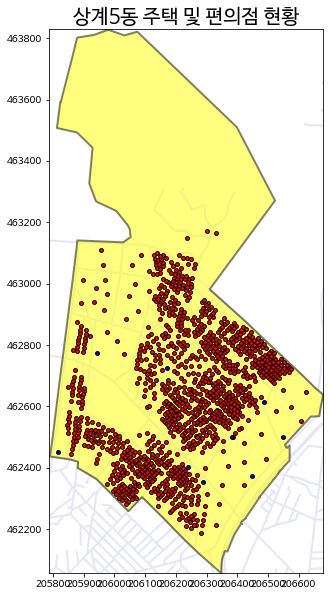

In [ ]:
add_to_plot = {"streets": Nowon_streets,"border":border_sanggye, "cli_tru":clients_sanggye,"fac_tru":facilities_sanggye}
plotter(plot_aux=add_to_plot, pt1_size=15, title='상계5동 주택 및 편의점 현황')# plot으로 상계동 현황 확인
# 확인해본 결과, 상계동은 다른 동에 비해서 단독 주택수가 압도적으로 많고, 데이터를 확인해 보았을 때, 현재 행정동 내
# 무인공병회수기 혹은 공병을 회수할 수 있을 것으로 예상되는 대형마트가 존재하지 않음을 확인함.

In [ ]:
ntw_nowon = spaghetti.Network(in_data=Nowon_streets)# 노원구의 도로 패턴으로 네트워크 생성

In [ ]:
ntw_nowon.snapobservations(clients_sanggye, "clients_sanggye", attribute=True)
clients_snapped_sanggye = spaghetti.element_as_gdf(
    ntw_nowon, pp_name="clients_sanggye", snapped=True
) # 상계 5동의 주택을 가장 가까운 도로에 할당
ntw_nowon.snapobservations(facilities_sanggye, "facilities_sanggye", attribute=True)
facilities_snapped_sanggye = spaghetti.element_as_gdf(
    ntw_nowon, pp_name="facilities_sanggye", snapped=True
) # 상계 5동의 편의점을 가장 가까운 도로에 할당
cost_matrix = ntw_nowon.allneighbordistances(
    sourcepattern=ntw_nowon.pointpatterns["clients_sanggye"],
    destpattern=ntw_nowon.pointpatterns["facilities_sanggye"],
) # 할당한 점들을 바탕으로 편의점과 주택간의 거리를 도로 기준으로 거리를 계산

In [ ]:
list(set(np.where(np.isfinite(cost_matrix)==False)[0].tolist())) # 폴리곤 오류로 인해 오류가 난 부분을 확인

[544,
 307,
 313,
 69,
 79,
 80,
 1109,
 1113,
 1114,
 1115,
 1116,
 989,
 1118,
 1119,
 359,
 360,
 1010,
 1011,
 1012]

In [ ]:
# clients_sanggye=house_arr[house_arr['행정동']=='상계5동'].reset_index().drop(list(set(np.where(np.isfinite(cost_matrix)==False)[0].tolist())))
# clients_sanggye["dv"] = ["x[%s]" % c for c in range(clients_sanggye.shape[0])]
# facilities_sanggye = conv_arr[conv_arr['행정동']=='상계5동'].reset_index()
# facilities_sanggye["dv"] = ["y[%s]" % c for c in range(facilities_sanggye.shape[0])]
# 폴리곤 오류 난 곳을 확인하기 위해서 이를 제거하고 파악하기 위해 사용했던 코드, 현재 사용하지 않음

In [ ]:
# add_to_plot = {"streets": Nowon_streets,"border":border_sanggye, "cli_tru":clients_sanggye,"fac_tru":facilities_sanggye}
# plotter(plot_aux=add_to_plot, pt1_size=1, title='상계5동 주택 및 편의점 현황')
# 폴리곤 오류 난 곳을 확인하기 위해서 이를 제거하고 파악하기 위해 사용했던 코드, 현재 사용하지 않음

In [ ]:
m_cost_matrix=inf_to_ed(clients_sanggye,facilities_sanggye,cost_matrix) # 해당 부분을 유클리드 거리로 대체

In [ ]:
clients_sanggye['weight']=clients_sanggye['연면적']/clients_sanggye['연면적'].sum() # 세대수, 가구수를 대체할 수 있는 연면적으로 가중치 사용
"""
가중치로 세대수와 가구수 대신 연면적을 사용한 이유:

1)건물관리대장에서 세대수와 가구수를 추출할 수 있지만, 현재 관련 데이터를 서울시열린데이터광장에서 다운로드를 받을 수 없는 문제 발생
2)입지 최적화를 진행하는 1순위 무인공병클러스터와 1순위 취약계층 클러스터링 모두 속하는 4개의 동에 대해서는 다음과 같은 가정을 통해
  세대수와 가구수를 연면적으로 대체함
  
  가) 전반적으로 같은 클러스터에 속한 행정동은 비슷한 수준의 공시지가를 형성하고 있음. 공시지가가 해당 행정동의 평균 소득을 대체하는 
      것을 고려하였을 때, 해당 지역은 비슷한 소득수준을 가지고 있음.
  나) 입지최적화로 선별한 행정동은 1순위 취약계층 클러스터에 속해있기 때문에, 대체적으로 낮은 공시지가를 가지고 있었음.
  다) 따라서, 소득수준이 높은(평균 소득수준이 높은) 지역에서 나타나는, 연면적은 크지 실제 거주 인원 수는 적은 문제에서 어느정도 자유로움
"""

'\n세대수와 가구수 대신 연면적을 사용한 이유:\n\n1)건물관리대장에서 세대수와 가구수를 추출할 수 있지만, 현재 관련 데이터를 서울시열린데이터광장에서 다운로드를 받을 수 없는 문제 발생\n2)입지 최적화를 진행하는 1순위 무인공병클러스터와 1순위 취약계층 클러스터링 모두 속하는 4개의 동에 대해서는 다음과 같은 가정을 통해\n  세대수와 가구수를 연면적으로 대체함\n  \n  가) 전반적으로 같은 클러스터에 속한 행정동은 비슷한 수준의 공시지가를 형성하고 있음. 공시지가가 해당 행정동의 평균 소득을 대체하는 \n      것을 고려하였을 때, 해당 지역은 비슷한 소득수준을 가지고 있음.\n  나) 입지최적화로 선별한 행정동은 1순위 취약계층 클러스터에 속해있기 때문에, 대체적으로 낮은 공시지가를 가지고 있었음.\n  다) 따라서, 소득수준이 높은(평균 소득수준이 높은) 지역에서 나타나는, 연면적은 크지 실제 거주 인원 수는 적은 문제에서 어느정도 자유로움\n'

In [ ]:
pmp_sanggye = FacilityLocationModel("pmp", ai=clients_sanggye['weight'] ,cij=m_cost_matrix, p=2)
# 상계동의 입지 최적화를 P-median을 통해서 계산
clients_sanggye, facilities_sanggye = add_results(pmp_sanggye, clients_sanggye, facilities_sanggye)

Solve Time: 0.029166725 minutes
Obj. Value: 302.3033337081359 total weighted distance with 2 selected facilities
Mean weighted distance per person: 302.303334


NameError: name 'add_legend' is not defined

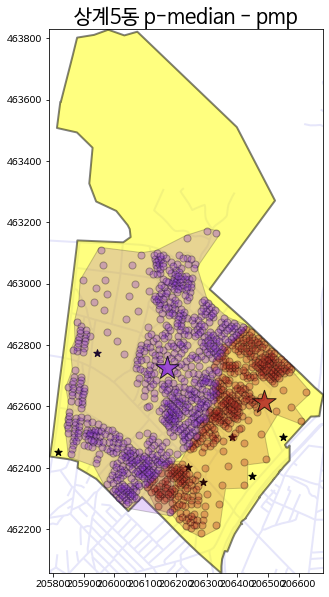

In [ ]:
aux_to_plot = {"streets": Nowon_streets, 'border':border_sanggye , "fac_tru": facilities_sanggye}
res_to_plot = {"cli_var": clients_sanggye, "fac_var": facilities_sanggye}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=200,
    pt2_size=60,
    model=pmp_sanggye,
    title='상계5동 p-median',
)
# P-median을 통한 상계동의 입지 최적화 결과를 지도로 출력

In [ ]:
facilities_sanggye[facilities_sanggye['pmp_sol']!='closed']
# 입지최적화 결과 선정된 편의점의 정보를 출력
# 이후 같은 방식으로 중계 2,3동, 가양 3동, 등촌 3동 입지 최적화 진행

,이름,구,행정동,x,y,w84_x,w84_y,geometry,dv,pmp_sol
35,GS25 상계역점,노원구,상계5동,127.073514,37.663161,206486.302463,462615.700512,POINT (206486.30246 462615.70051),y[0],"[x[0], x[4], x[7], x[10], x[11], x[12], x[13],..."
38,GS25 상계대박점,노원구,상계5동,127.069955,37.664155,206172.199972,462725.800029,POINT (206172.19997 462725.80003),y[3],"[x[1], x[2], x[3], x[5], x[6], x[8], x[9], x[2..."


In [ ]:
clients_junggye=house_arr[house_arr['행정동']=='중계2'].reset_index()
clients_junggye["dv"] = ["x[%s]" % c for c in range(clients_junggye.shape[0])]
facilities_junggye = conv_arr[conv_arr['행정동']=='중계2.3동'].reset_index()
facilities_junggye["dv"] = ["y[%s]" % c for c in range(facilities_junggye.shape[0])]
display(clients_junggye)
display(facilities_junggye)

,index,고유번호,구,행정동,건물용도분류명,연면적,세부용도명,x,y,w84_x,w84_y,geometry,dv
0,0,31900214,노원구,중계2,주거용,3242.02,연립주택,127.069303,37.640906,206116.587873,460145.358823,POINT (206116.58787 460145.35882),x[0]
1,1,31901298,노원구,중계2,주거용,2585.52,연립주택,127.069903,37.641076,206169.560356,460164.239714,POINT (206169.56036 460164.23971),x[1]
2,2,31903556,노원구,중계2,주거용,937.20,연립주택,127.068893,37.641051,206080.431960,460161.390450,POINT (206080.43196 460161.39045),x[2]
3,9,31895193,노원구,중계2,주거용,4638.76,아파트,127.061126,37.640372,205394.979274,460085.531534,POINT (205394.97927 460085.53153),x[3]
4,10,31903011,노원구,중계2,주거용,9030.03,아파트,127.061848,37.640717,205458.695592,460123.862048,POINT (205458.69559 460123.86205),x[4]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,145,31895792,노원구,중계2,주거용,12266.82,아파트,127.066073,37.647108,205831.056807,460833.441676,POINT (205831.05681 460833.44168),x[93]
94,146,31895793,노원구,중계2,주거용,13685.06,아파트,127.066735,37.647714,205889.397289,460900.810419,POINT (205889.39729 460900.81042),x[94]
95,148,31899211,노원구,중계2,주거용,12266.82,아파트,127.067069,37.647288,205918.935831,460853.513631,POINT (205918.93583 460853.51363),x[95]
96,150,31896651,노원구,중계2,주거용,10263.40,아파트,127.064858,37.646099,205723.889847,460721.449083,POINT (205723.88985 460721.44908),x[96]


,index,이름,구,행정동,x,y,w84_x,w84_y,geometry,dv
0,27,GS25 중계무지개점,노원구,중계2.3동,127.065451,37.643585,205776.398448,460442.399771,POINT (205776.39845 460442.39977),y[0]
1,28,CU 중계그린점,노원구,중계2.3동,127.064054,37.643214,205653.203687,460401.199673,POINT (205653.20369 460401.19967),y[1]
2,29,GS25 중계행운점,노원구,중계2.3동,127.069340,37.644704,206119.604334,460566.799560,POINT (206119.60433 460566.79956),y[2]
3,30,CU 중계매일점,노원구,중계2.3동,127.062951,37.641330,205555.997321,460192.000259,POINT (205555.99732 460192.00026),y[3]
4,31,세븐일레븐 중계씨앤미점,노원구,중계2.3동,127.068018,37.640599,206003.200313,460111.199973,POINT (206003.20031 460111.19997),y[4]
5,32,GS25 중계그린점,노원구,중계2.3동,127.063411,37.643035,205596.397774,460381.199565,POINT (205596.39777 460381.19957),y[5]
6,33,GS25 중계브라운점,노원구,중계2.3동,127.064537,37.639931,205696.002740,460036.799627,POINT (205696.00274 460036.79963),y[6]
7,34,CU 중계상아점,노원구,중계2.3동,127.063901,37.639136,205639.999986,459948.500036,POINT (205639.99999 459948.50004),y[7]


NameError: name 'add_legend' is not defined

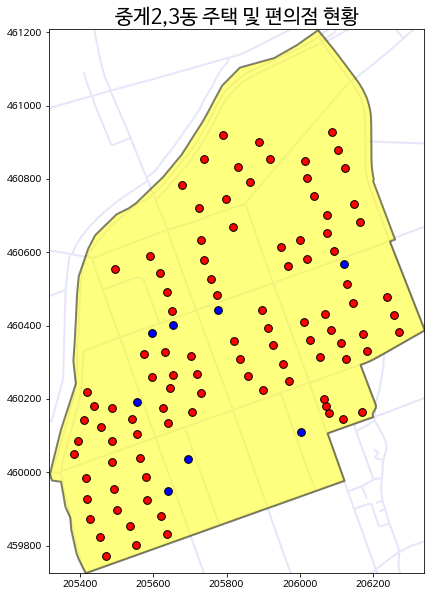

In [ ]:
add_to_plot = {"streets": Nowon_streets,"border":border_junggye, "cli_tru":clients_junggye,"fac_tru":facilities_junggye}
plotter(plot_aux=add_to_plot, pt1_size=60, title='중게2,3동 주택 및 편의점 현황')

In [ ]:
ntw_nowon.snapobservations(clients_junggye, "clients_junggye", attribute=True)
clients_snapped_junggye = spaghetti.element_as_gdf(
    ntw_nowon, pp_name="clients_junggye", snapped=True
)
ntw_nowon.snapobservations(facilities_junggye, "facilities_junggye", attribute=True)
facilities_snapped_junggye = spaghetti.element_as_gdf(
    ntw_nowon, pp_name="facilities_junggye", snapped=True
)
cost_matrix = ntw_nowon.allneighbordistances(
    sourcepattern=ntw_nowon.pointpatterns["clients_junggye"],
    destpattern=ntw_nowon.pointpatterns["facilities_junggye"],
)

In [ ]:
list(set(np.where(np.isfinite(cost_matrix)==False)[0].tolist()))

[44, 13, 46, 16, 48, 18, 83, 87]

In [ ]:
m_cost_matrix=inf_to_ed(clients_junggye,facilities_junggye,cost_matrix)

In [ ]:
m_cost_matrix[13,:]

array([231.56307742, 201.36884617, 524.10189224, 176.34032073,
       291.65770127, 213.44097004, 181.92988983, 281.89214502])

In [ ]:
list(set(np.where(np.isfinite(m_cost_matrix)==False)[0].tolist()))

[]

NameError: name 'add_legend' is not defined

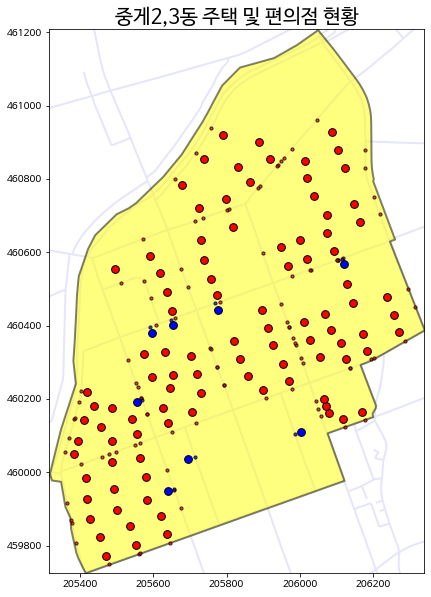

In [ ]:
add_to_plot = {"streets": Nowon_streets,
               "border":border_junggye,
               "cli_tru":clients_junggye,
               "fac_tru":facilities_junggye,
               "cli_snp": clients_snapped_junggye,
               "fac_snp": facilities_snapped_junggye,
              }
plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60, pt2_size=10, title='중게2,3동 주택 및 편의점 현황')
# 시각적으로 점이 어떻게 옮겨지는지 확인 가능함

In [ ]:
clients_junggye['weight']=clients_junggye['연면적']/clients_junggye['연면적'].sum()

In [ ]:
pmp_junggye = FacilityLocationModel("pmp", ai=clients_junggye['weight'] ,cij=m_cost_matrix, p=1)
clients_junggye, facilities_junggye = add_results(pmp_junggye, clients_junggye, facilities_junggye)

Solve Time: 0.0014500029 minutes
Obj. Value: 542.212122713853 total weighted distance with 1 selected facilities
Mean weighted distance per person: 542.212123


NameError: name 'add_legend' is not defined

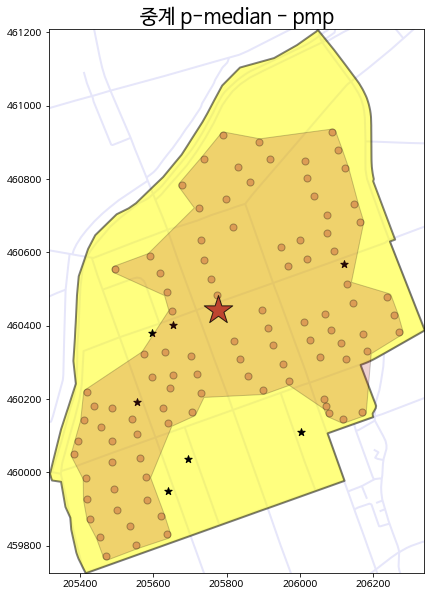

In [ ]:
aux_to_plot = {"streets": Nowon_streets, 'border':border_junggye , "fac_tru": facilities_junggye}
res_to_plot = {"cli_var": clients_junggye, "fac_var": facilities_junggye}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=pmp_junggye,
    title='중계 p-median',
)

In [ ]:
facilities_junggye[facilities_junggye['pmp_sol']!='closed']

,index,이름,구,행정동,x,y,w84_x,w84_y,geometry,dv,pmp_sol
0,27,GS25 중계무지개점,노원구,중계2.3동,127.065451,37.643585,205776.398448,460442.399771,POINT (205776.39845 460442.39977),y[0],"[x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7..."


In [ ]:
clients_gayang=house_arr[house_arr['행정동']=='가양3동']
clients_gayang["dv"] = ["x[%s]" % c for c in range(clients_gayang.shape[0])]
facilities_gayang = conv_arr[conv_arr['행정동']=='가양3동']
facilities_gayang["dv"] = ["y[%s]" % c for c in range(facilities_gayang.shape[0])]
display(clients_gayang)
display(facilities_gayang)

,고유번호,구,행정동,건물용도분류명,연면적,세부용도명,x,y,w84_x,w84_y,geometry,dv
19561,32051142,강서구,가양3동,주거용,14716.30,아파트,126.857665,37.563281,187424.622967,451537.107154,POINT (187424.62297 451537.10715),x[0]
19562,32051405,강서구,가양3동,주거용,14109.09,아파트,126.858140,37.563209,187466.505016,451529.046727,POINT (187466.50502 451529.04673),x[1]
19563,32049481,강서구,가양3동,주거용,4387.28,아파트,126.858066,37.563543,187460.037711,451566.105886,POINT (187460.03771 451566.10589),x[2]
19564,32051113,강서구,가양3동,주거용,14401.84,아파트,126.858770,37.563366,187522.255986,451546.336757,POINT (187522.25599 451546.33676),x[3]
19569,32051163,강서구,가양3동,주거용,13246.85,아파트,126.857917,37.562010,187446.683287,451395.947270,POINT (187446.68329 451395.94727),x[4]
...,...,...,...,...,...,...,...,...,...,...,...,...
19660,32053558,강서구,가양3동,주거용,5864.73,아파트,126.858431,37.560510,187491.814159,451229.393973,POINT (187491.81416 451229.39397),x[57]
19662,32053248,강서구,가양3동,주거용,6264.81,아파트,126.857248,37.560634,187387.324613,451243.358843,POINT (187387.32461 451243.35884),x[58]
19663,32053247,강서구,가양3동,주거용,6264.81,아파트,126.856706,37.560908,187339.431560,451273.810537,POINT (187339.43156 451273.81054),x[59]
19664,32050845,강서구,가양3동,주거용,5297.47,아파트,126.856487,37.561196,187320.135078,451305.854034,POINT (187320.13508 451305.85403),x[60]


,이름,구,행정동,x,y,w84_x,w84_y,geometry,dv
55,GS25 가양7단지점,강서구,가양3동,126.862057,37.560862,187812.250653,451267.999565,POINT (187812.25065 451267.99956),y[0]
56,세븐일레븐 가양프라자점,강서구,가양3동,126.860194,37.561394,187647.753168,451327.249667,POINT (187647.75317 451327.24967),y[1]
57,세븐일레븐 가양9단지점,강서구,가양3동,126.863404,37.559584,187931.003943,451125.999486,POINT (187931.00394 451125.99949),y[2]
58,미니스톱 비즈메트로점,강서구,가양3동,126.860932,37.559117,187712.504382,451074.499381,POINT (187712.50438 451074.49938),y[3]
59,GS25 가양글로벌점,강서구,가양3동,126.858782,37.560381,187522.750185,451214.999627,POINT (187522.75019 451214.99963),y[4]
60,GS25 가양8단지점,강서구,가양3동,126.857971,37.562610,187451.504063,451462.495989,POINT (187451.50406 451462.49599),y[5]
61,이마트24 뉴가양8단지점,강서구,가양3동,126.857991,37.562560,187453.253959,451456.999412,POINT (187453.25396 451456.99941),y[6]


NameError: name 'add_legend' is not defined

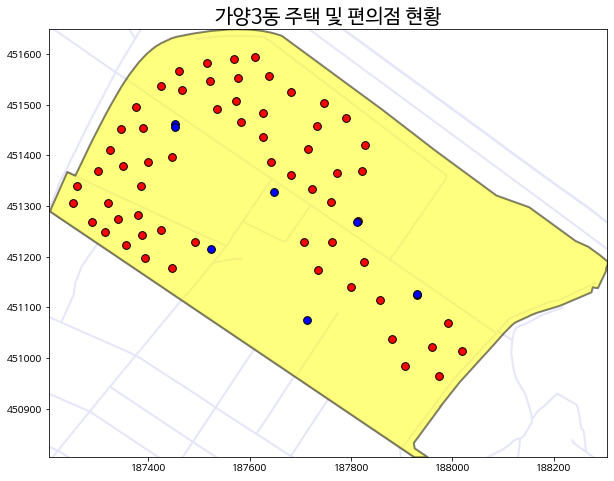

In [ ]:
add_to_plot = {"streets": Gangseo_streets,"border":border_gayang, "cli_tru":clients_gayang,"fac_tru":facilities_gayang}
plotter(plot_aux=add_to_plot, pt1_size=60, title='가양3동 주택 및 편의점 현황')

In [ ]:
ntw_gangseo = spaghetti.Network(in_data=Gangseo_streets)

In [ ]:
ntw_gangseo.snapobservations(clients_gayang, "clients_gayang", attribute=True)
clients_snapped_gayang = spaghetti.element_as_gdf(
    ntw_gangseo, pp_name="clients_gayang", snapped=True
)
ntw_gangseo.snapobservations(facilities_gayang, "facilities_gayang", attribute=True)
facilities_snapped_gayang = spaghetti.element_as_gdf(
    ntw_gangseo, pp_name="facilities_gayang", snapped=True
)
cost_matrix = ntw_gangseo.allneighbordistances(
    sourcepattern=ntw_gangseo.pointpatterns["clients_gayang"],
    destpattern=ntw_gangseo.pointpatterns["facilities_gayang"],
)

In [ ]:
list(set(np.where(np.isfinite(cost_matrix)==False)[0].tolist()))

[]

In [ ]:
m_cost_matrix=inf_to_ed(clients_gayang,facilities_gayang,cost_matrix)

NameError: name 'add_legend' is not defined

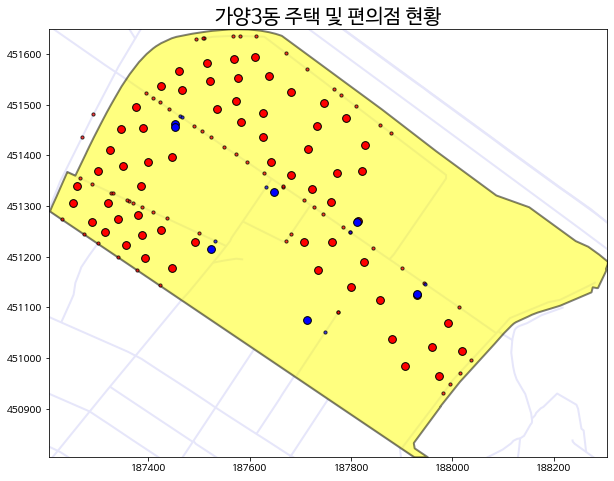

In [ ]:
add_to_plot = {"streets": Gangseo_streets,
               "border":border_gayang,
               "cli_tru":clients_gayang,
               "fac_tru":facilities_gayang,
               "cli_snp": clients_snapped_gayang,
               "fac_snp": facilities_snapped_gayang,
              }
plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60, pt2_size=10, title='가양3동 주택 및 편의점 현황')

In [ ]:
clients_gayang['weight']=clients_gayang['연면적']/clients_gayang['연면적'].sum()

In [ ]:
pmp_gayang = FacilityLocationModel("pmp", ai=clients_gayang['weight'] ,cij=cost_matrix, p=1)
clients_gayang, facilities_gayang = add_results(pmp_gayang, clients_gayang, facilities_gayang)


Solve Time: 0.0007833349 minutes
Obj. Value: 480.4793359179015 total weighted distance with 1 selected facilities
Mean weighted distance per person: 480.479336


In [ ]:
facilities_gayang[facilities_gayang['pmp_sol']!='closed']

,이름,구,행정동,x,y,w84_x,w84_y,geometry,dv,pmp_sol
56,세븐일레븐 가양프라자점,강서구,가양3동,126.860194,37.561394,187647.753168,451327.249667,POINT (187647.75317 451327.24967),y[1],"[x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7..."


NameError: name 'add_legend' is not defined

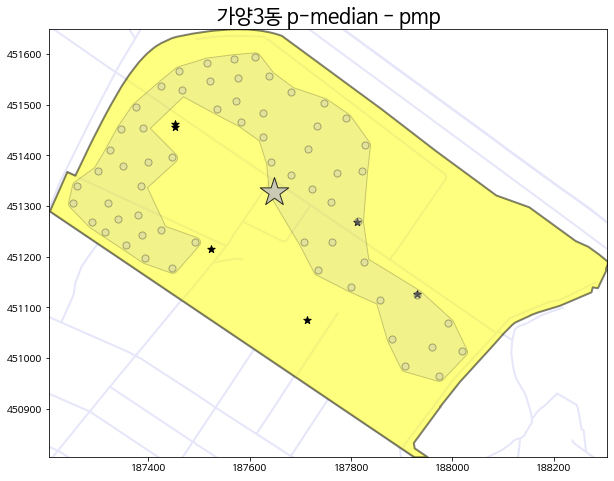

In [ ]:
aux_to_plot = {"streets": Gangseo_streets, 'border':border_gayang , "fac_tru": facilities_gayang}
res_to_plot = {"cli_var": clients_gayang, "fac_var": facilities_gayang}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=pmp_gayang,
    title='가양3동 p-median',
)

In [ ]:
clients_deungchon=house_arr[house_arr['행정동']=='등촌3동']
clients_deungchon["dv"] = ["x[%s]" % c for c in range(clients_deungchon.shape[0])]
facilities_deungchon = conv_arr[conv_arr['행정동']=='등촌3동']
facilities_deungchon["dv"] = ["y[%s]" % c for c in range(facilities_deungchon.shape[0])]
display(clients_deungchon)
display(facilities_deungchon)

,고유번호,구,행정동,건물용도분류명,연면적,세부용도명,x,y,w84_x,w84_y,geometry,dv
15096,32044026,강서구,등촌3동,주거용,546.78,다가구주택,126.843705,37.558782,186190.351131,451039.657587,POINT (186190.35113 451039.65759),x[0]
15100,32050509,강서구,등촌3동,주거용,467.50,다가구주택,126.844304,37.558737,186243.265046,451034.569279,POINT (186243.26505 451034.56928),x[1]
15101,32040960,강서구,등촌3동,주거용,475.30,다가구주택,126.844163,37.558747,186230.808613,451035.687898,POINT (186230.80861 451035.68790),x[2]
15102,32041228,강서구,등촌3동,주거용,450.47,다가구주택,126.844031,37.558767,186219.165301,451037.924418,POINT (186219.16530 451037.92442),x[3]
15152,32032937,강서구,등촌3동,주거용,2472.69,아파트,126.843061,37.559061,186133.552174,451070.756419,POINT (186133.55217 451070.75642),x[4]
...,...,...,...,...,...,...,...,...,...,...,...,...
15422,32033099,강서구,등촌3동,주거용,530.28,다세대주택,126.848618,37.558198,186624.330461,450974.157378,POINT (186624.33046 450974.15738),x[122]
15424,32049318,강서구,등촌3동,주거용,515.79,다세대주택,126.847354,37.558429,186512.713161,451000.004436,POINT (186512.71316 451000.00444),x[123]
15425,32033643,강서구,등촌3동,주거용,17338.46,아파트,126.847830,37.558507,186554.789671,451008.555734,POINT (186554.78967 451008.55573),x[124]
15426,32032545,강서구,등촌3동,주거용,534.20,다세대주택,126.848175,37.558239,186585.261744,450978.774862,POINT (186585.26174 450978.77486),x[125]


,이름,구,행정동,x,y,w84_x,w84_y,geometry,dv
62,GS25 발산에너지점,강서구,등촌3동,126.841561,37.559097,186000.996541,451074.999377,POINT (186000.99654 451074.99938),y[0]
63,CU 등촌5단지점,강서구,등촌3동,126.845047,37.561674,186309.502872,451360.499314,POINT (186309.50287 451360.49931),y[1]
64,GS25 강서부영점,강서구,등촌3동,126.842589,37.562874,186092.501789,451493.999653,POINT (186092.50179 451493.99965),y[2]
65,CU 강서스타점,강서구,등촌3동,126.843678,37.558587,186187.995659,451017.999968,POINT (186187.99566 451017.99997),y[3]
66,미니스톱 발산역점,강서구,등촌3동,126.838765,37.559301,185754.001301,451097.998920,POINT (185754.00130 451097.99892),y[4]
67,CU 등촌SBS점,강서구,등촌3동,126.851090,37.562439,186843.499957,451444.499078,POINT (186843.49996 451444.49908),y[5]
68,GS25 등촌NC점,강서구,등촌3동,126.840039,37.561433,185866.995616,451334.499052,POINT (185866.99562 451334.49905),y[6]
69,미니스톱 가양대교점,강서구,등촌3동,126.854627,37.560770,187155.749197,451258.749232,POINT (187155.74920 451258.74923),y[7]
70,GS25 등촌서낭점,강서구,등촌3동,126.846210,37.558741,186411.750896,451034.749724,POINT (186411.75090 451034.74972),y[8]
71,GS25 가양데시앙점,강서구,등촌3동,126.847772,37.564662,186550.748271,451691.749069,POINT (186550.74827 451691.74907),y[9]


NameError: name 'add_legend' is not defined

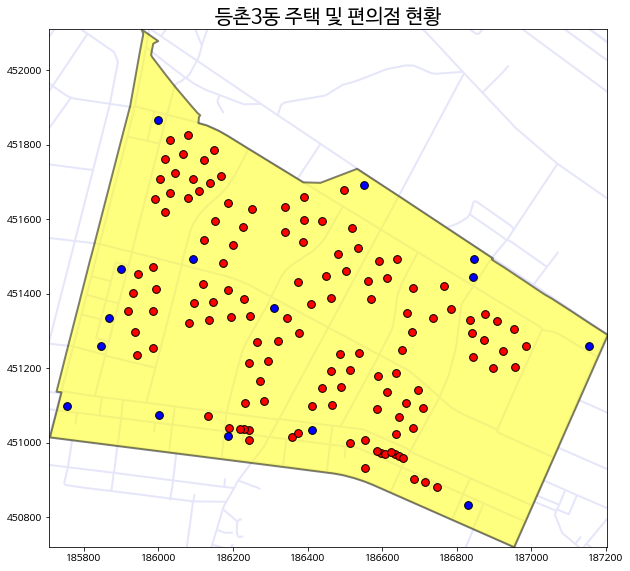

In [ ]:
add_to_plot = {"streets": Gangseo_streets,"border":border_deungchon, "cli_tru":clients_deungchon,"fac_tru":facilities_deungchon}
plotter(plot_aux=add_to_plot, pt1_size=60, title='등촌3동 주택 및 편의점 현황')

In [ ]:
ntw_gangseo.snapobservations(clients_deungchon, "clients_deungchon", attribute=True)
clients_snapped_deungchon = spaghetti.element_as_gdf(
    ntw_gangseo, pp_name="clients_deungchon", snapped=True
)
ntw_gangseo.snapobservations(facilities_deungchon, "facilities_deungchon", attribute=True)
facilities_snapped_deungchon = spaghetti.element_as_gdf(
    ntw_gangseo, pp_name="facilities_deungchon", snapped=True
)
cost_matrix = ntw_gangseo.allneighbordistances(
    sourcepattern=ntw_gangseo.pointpatterns["clients_deungchon"],
    destpattern=ntw_gangseo.pointpatterns["facilities_deungchon"],
)

In [ ]:
list(set(np.where(np.isfinite(cost_matrix)==False)[0].tolist()))

[]

NameError: name 'add_legend' is not defined

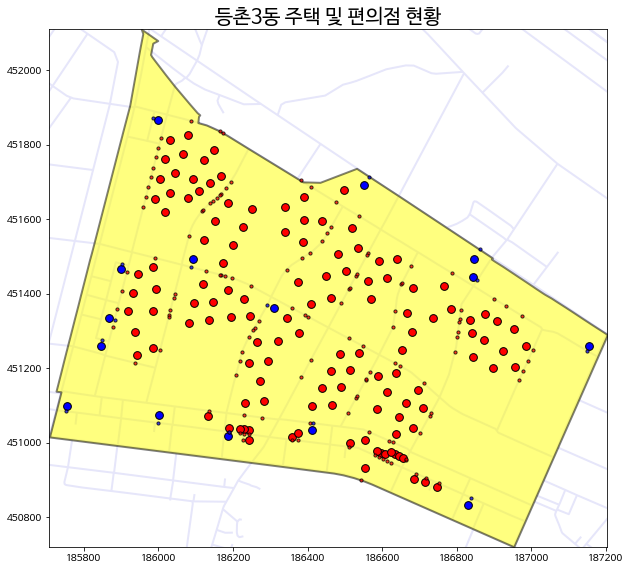

In [ ]:
add_to_plot = {"streets": Gangseo_streets,
               "border":border_deungchon,
               "cli_tru":clients_deungchon,
               "fac_tru":facilities_deungchon,
               "cli_snp": clients_snapped_deungchon,
               "fac_snp": facilities_snapped_deungchon,
              }
plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60, pt2_size=10, title='등촌3동 주택 및 편의점 현황')

In [ ]:
clients_deungchon['weight']=clients_deungchon['연면적']/clients_deungchon['연면적'].sum()

In [ ]:
pmp_deungchon = FacilityLocationModel("pmp", ai=clients_deungchon['weight'] ,cij=cost_matrix, p=1)
clients_deungchon, facilities_deungchon = add_results(pmp_deungchon, clients_deungchon, facilities_deungchon)

Solve Time: 0.0037500075000000003 minutes
Obj. Value: 446.0492013800063 total weighted distance with 1 selected facilities
Mean weighted distance per person: 446.049201


NameError: name 'add_legend' is not defined

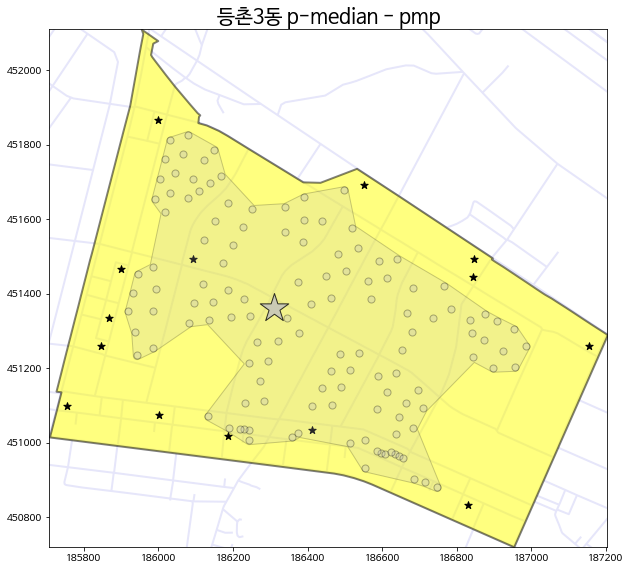

In [ ]:
aux_to_plot = {"streets": Gangseo_streets, 'border':border_deungchon , "fac_tru": facilities_deungchon}
res_to_plot = {"cli_var": clients_deungchon, "fac_var": facilities_deungchon}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=pmp_deungchon,
    title='등촌3동 p-median',
)

In [ ]:
facilities_deungchon[facilities_deungchon['pmp_sol']!='closed']

,이름,구,행정동,x,y,w84_x,w84_y,geometry,dv,pmp_sol
63,CU 등촌5단지점,강서구,등촌3동,126.845047,37.561674,186309.502872,451360.499314,POINT (186309.50287 451360.49931),y[1],"[x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7..."


In [ ]:
house_arr['행정동'].unique()

array(['길음1동', '용문동', '청구동', '행당2동', '돈암2동',
       '삼각산동', '상계5동', '등촌3동', '화곡1동',
       '화곡8동', '가양3동', '구로4동', '청림동', '성현동',
       '하계2동', '중계2'], dtype=object)

추후 보완할 내역:
1) API와 연동을 통한 실제 지도를 배경으로 설정  
2) pixel 문제로 인한 범례 출력시 생기는 오류 해결

해결한다면 나중에 Reference Code로써 추후 입지선정 관련 주제분석을 진행할 때, 좋은 참고용 code가 될 수 있을 것으로 보임.